# Problem Set 3: Merging and regular expressions

**Total points (without extra credit)**: 44

**Background on the policy context**: here, we're going to use two datasets to practice reshaping, merging, and regular expression patterns. Both datasets relate to the broader issue of which employers might be violating the rights of temporary guestworkers granted visas under the H-2A program. Here are some articles about potential exploitation of guestworkers by firms and inequality caused by minimal oversight:

- News media coverage of labor abuses of temporary guestworkers: https://www.buzzfeednews.com/article/kenbensinger/the-pushovers 
- GAO report on labor abuses of temporary guestworkers: https://www.gao.gov/products/gao-15-154

The following datasets are located in `pset3_inputdata` (need to unzip): 

- `jobs`: a dataset of guestworker jobs posted by many employers, some of whom have been debarred (banned) from the program for labor abuses; others not debarred
- `debar`: a dataset of employers who committed violations of labor regulations meant to protect temporary guestworkers 


## Resources from class

- [Lecture](https://github.com/jhaber-zz/QSS20_public/blob/main/slides/06_qss20_w23_mergereshape.pdf) and [activity](https://github.com/jhaber-zz/QSS20_public/blob/main/activities/03_reshaping_merging_solutions.ipynb) on exact merging
- [Lecture](https://github.com/jhaber-zz/QSS20_public/blob/main/slides/07_qss20_w23_regex.pdf) and [activity](https://github.com/jhaber-zz/QSS20_public/blob/main/activities/04_regex_blank.ipynb) on regular expressions (both coming in class on Feb. 1)
- DataCamp modules on both of these

# 0. Load packages & data (1 point total)

In [92]:
## helpful packages
import pandas as pd
import numpy as np
import random
import re
import os

## repeated printouts
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


## 0.1 Load data (0 points)

Load the following dataset stored in `pset3_inputdata`&mdash;`debar.csv`&mdash;storing it as a dataframe named `debar`. This represents employers temporarily banned from hiring workers.

View the `head()` and columns of this dataframe.

In [93]:
## Load Data
debar = pd.read_csv("pset3_inputdata/debar.csv")
debar.head()

,Name,"City, State",Violation,Duration,Start date,End date
0,J&J Harvesting,"Leads, ND",Failure to respond to audit (partial response),2 years,1/19/2014,1/18/2016
1,"Stahlman Apiaries, Inc","Selby, SD",Failure to respond to audit (partial response),1 year,2/19/2015,2/14/2016
2,Trust Nursery,"Pulaski, NY",Failure to respond to audit (partial response),1 year,3/21/2014,3/20/2015
3,Anton Fertilizer Inc.,"Dighton, KS",Failure to respond to audit (no response),2 years,3/30/2014,3/29/2016
4,"Great Plains Fluid Service, Inc.","Greensburg, KS",Failure to respond to audit (no response),2 years,3/30/2014,3/29/2016


The most notable column names mean as follows:
- `Name`:	Company name of agricultural employer
- `City, State`:	City and state where employer located
- `Violation`:	Type of program violation
- `Start date`:	Start date of debarment (temporary ban)

## 0.2 Inspect data (1 point)

Print the number of rows in `debar` versus the number of unique employer names (`Name`). Is there one row per employer or multiple rows for some employers?

In [94]:
## Getting values
print("Number of rows: " + str(len(debar)))
print("Number of Unique Employer Names: " + str(debar["Name"].nunique()))

Number of rows: 114
Number of Unique Employer Names: 98


#### Since there are more rows than unique employer names, there are multiple rows for some employers.

# 1. Reshape data and check duplicates (19 points total)

## 1.1 Make indicator for violation number (2 points)

To make it possible to reshape data, make an indicator for the violation number for each business. The indicator should take the value of `viol` if it's the first row/potential violation, `viol2` if the second row/potential violation, etc.

**Hint:**
- One way to do this is by using an if-else statement to check whether the business name is the same as in the row above (assuming rows are ordered by name). Grouping by employer name and checking the number of unique offenses would also work.

In [95]:
## constructing violnum
debar = debar.sort_values("Name").reset_index(drop=True)
debar["violnum"] = ["viol" if (i == 0 or debar.loc[i-1, "Name"] != debar.loc[i, "Name"])\
        else "viol2"\
        for i in range(len(debar))]
debar

,Name,"City, State",Violation,Duration,Start date,End date,violnum
0,69 Farms LLC,"Preston, Idaho",Failure to respond to audit request,2 years,9/24/2016,9/23/2018,viol
1,AB Ranch,"Stephenville, Texas",Failure to respond to audit request,2 years,4/28/2017,4/27/2019,viol
2,Abe- Nancy Froese,"Seminole, TX",Failure to respond to audit request,2 years,11/23/2017,11/23/2019,viol
3,Agecy I LLC,"Idabel, OK",Impeding the Audit Process – Non- Response,2 years,8/27/2015,8/26/2017,viol
4,"Agecy II, LLC","Ipswich, SD",Impeding the Audit Process – Non- Response,2 years,3/25/2015,3/24/2017,viol
...,...,...,...,...,...,...,...
109,Xavier Horne,"Lyons, Georgia",Non-payment of certification fee,1 year,6/16/2016,6/15/2017,viol
110,Xavier Horne,"Lyons, Georgia",Failure to respond to audit request,2 years,9/27/2017,9/26/2019,viol2
111,Yesenia Perez,"Axson, Georgia",Failure to respond to audit request,2 years,9/27/2017,9/26/2019,viol
112,Yolanda Chavez,"Santa Maria, CA",Non Payment,1 year,7/23/2014,7/22/2015,viol


## 1.2 Clean up state names (3 points)

Inspect the state names in the business violation data. Which states have names sometimes indicated in long format vs. two-letter abbreviation, e.g. "New Hampshire" vs. "NH"? Which of these may have more than one violation?

**Hint:** 
- One way to do this is to extract state names from the `City, State` column using regex and/or string methods.
- The simplest way to check if a state may have more than one violation is to check how many times they appear using `value_counts()`. 

In [96]:
## Counting states
debar["state"] = [cs.split(", ")[1] if type(cs) == str else "na" for cs in debar["City, State"]]
debar.value_counts("state")

state
TX                14
GA                10
KS                 9
Georgia            9
FL                 8
KY                 5
SD                 5
UT                 4
Texas              4
ND                 3
CO                 3
NY                 3
CA                 3
North Dakota       3
MT                 2
OK                 2
Florida            2
AR                 2
LA                 2
Utah               2
MA                 2
IL                 1
California         1
Arkansas           1
ID                 1
na                 1
Idaho              1
Kansas             1
Louisiana          1
Vermont            1
MD                 1
ME                 1
MN                 1
Massachusetts      1
North Carolina     1
SC                 1
Tennessee          1
AK                 1
dtype: int64

#### The states Georgia, Texas, North Dakota, Florida, Utah, California, Arkansas, Idaho, Kansas, Louisiana,and Massachusetts have long format and two-letter abbreviation. 
#### The states Vermont, North Carolina, and Tennessee have only the long format.
#### The rest of the states have only the two-letter abbreviation.
#### Using the table above, one can see which states have multiple violations.

To make the state names consistent with the jobs data below, convert any discrepant state names to the two-letter abbreviation format. 

**Hints:**
- You could do this for all state names (to be safe) or only those you just identified. 
- If you want to change ANY discrepant state names from long format to two-letter format (i.e., a complete conversion), you can load state names from a complete name/abbreviation crosswalk and use that to change state names. Here is code to load in such a list ([from this blog](https://towardsdatascience.com/state-name-to-state-abbreviation-crosswalks-6936250976c)):
```python
crosswalk_url = 'http://app02.clerk.org/menu/ccis/Help/CCIS%20Codes/state_codes.html'
pd.read_html(crosswalk_url)[0]
```

In [97]:
## Change states
crosswalk_url = 'http://app02.clerk.org/menu/ccis/Help/CCIS%20Codes/state_codes.html'
convert = pd.read_html(crosswalk_url)[0]
to_code = {}
for index, row in convert.iterrows():
    to_code[row["Description"]] = row["Code"]
debar["state"] = [s if len(s)==2 else to_code[s] for s in debar["state"]]

debar["City, State"] = [s if (type(s) != str or len(s.split(", ")[1])==2)\
                        else s.split(", ")[0] + ", " +  to_code[s.split(", ")[1]]\
                        for s in debar["City, State"]]

# Testing to make sure no long form
debar["state"].unique()

array(['ID', 'TX', 'OK', 'SD', 'ND', 'FL', 'UT', 'KS', 'MA', 'LA', 'GA',
       'MT', 'KY', 'ME', 'NC', 'SC', 'CO', 'AR', 'CA', 'MN', 'TN', 'NY',
       'MD', 'AK', 'VT', 'na', 'IL'], dtype=object)

## 1.3 Investigate duplicated rows (4 points)

A. Create a new column in `debar`, `is_repeated`, that tells us whether an employer (`Name`) is repeated > 1 times.

*Hint*: there are multiple ways to solve this but some possibilities to get the list of names that are repeated are:
- Using `value_counts()` on the `Name` variable and extracting the index from that value counts 
- Using groupby to count the rows attached to one name

B. Print the rows where `is_repeated == True` and interpret with at least a sentence. If you notice any cases of duplicate business names where 'City, State' does NOT match exactly, check these manually and make them consistent.

C. Subset to the rows where `is_repeated == True` and save that data as `mult_debar`. Print the head() and shape

In [98]:
counts = debar["Name"].value_counts()
counts = counts[counts > 1]
debar["is_repeated"] = np.where(debar["Name"].isin(counts.index), True, False)

debar[debar["is_repeated"]]

# Based on Google, Loewen Harvesting is located in Brownfield not Brownville
before = debar.loc[61, "City, State"]
debar.loc[61, "City, State"] = 'Brownfield, TX'
print("Before: " + before + " After: " + debar.loc[61, "City, State"])

# Based on Google Altheimer Alaska doesn't exist
before = debar.loc[67, "City, State"]
debar.loc[67, "City, State"] = 'Altheimer, AR'
print("Before: " + before + " After: " + debar.loc[67, "City, State"])

mult_debar = debar[debar["is_repeated"]]
mult_debar.head()
mult_debar.shape

,Name,"City, State",Violation,Duration,Start date,End date,violnum,state,is_repeated
7,Annabella Land & Cattle,"Annabella, UT",Non-payment,1 year,5/9/2014,5/8/2015,viol,UT,True
8,Annabella Land & Cattle,"Annabella, UT",Non Payment,1 year,5/9/2014,5/9/2015,viol2,UT,True
10,Autumn Hill Orchard,"Groton, MA",Failure to respond to audit (no response),2 years,7/6/2014,7/5/2016,viol,MA,True
11,Autumn Hill Orchard,"Groton, MA",Impeding the Audit Process – Non- Response,2 years,7/6/2014,7/5/2016,viol2,MA,True
15,"Caddo Creek Ranch, dba Paradise Ranch","Caddo, TX",Impeding the Audit Process – Partial- Response,2 years,7/20/2014,7/19/2016,viol,TX,True
16,"Caddo Creek Ranch, dba Paradise Ranch","Caddo, TX",Failure to respond to audit (partial response),2 years,7/20/2014,7/19/2016,viol2,TX,True
19,Cisco Produce Inc.,"Cairo, GA",Failure to respond to audit (no response),2 years,12/10/2014,12/9/2016,viol,GA,True
20,Cisco Produce Inc.,"Cairo, GA",Impeding the Audit Process – Non- Response,2 years,12/10/2015,12/9/2017,viol2,GA,True
30,Dove Creek Farms,"Mount Vernon, TX",Failure to Respond to Audit Request,2 years,2/9/2018,2/8/2020,viol,TX,True
31,Dove Creek Farms,"Mount Vernon, TX",Failure to respond to audit request,2 years,2/9/2018,2/8/2018,viol2,TX,True


Before: Brownsville, TX After: Brownfield, TX
Before: Altheimer, AK After: Altheimer, AR


,Name,"City, State",Violation,Duration,Start date,End date,violnum,state,is_repeated
7,Annabella Land & Cattle,"Annabella, UT",Non-payment,1 year,5/9/2014,5/8/2015,viol,UT,True
8,Annabella Land & Cattle,"Annabella, UT",Non Payment,1 year,5/9/2014,5/9/2015,viol2,UT,True
10,Autumn Hill Orchard,"Groton, MA",Failure to respond to audit (no response),2 years,7/6/2014,7/5/2016,viol,MA,True
11,Autumn Hill Orchard,"Groton, MA",Impeding the Audit Process – Non- Response,2 years,7/6/2014,7/5/2016,viol2,MA,True
15,"Caddo Creek Ranch, dba Paradise Ranch","Caddo, TX",Impeding the Audit Process – Partial- Response,2 years,7/20/2014,7/19/2016,viol,TX,True


(32, 9)

#### We noticed that index 60 and 61 didn't match as Loewen Harvesting LLC is listed as in Brownfield, TX in one and Brownsville, TX in the other. We googled and found that Loewen Harvesting actually exists in Brownfield, TX and manually changed the wrong one.
#### We also noticed that Maple Ridge Custom Services on indexes 66 and 67 are listed as Altheimer, AR and Altheimer, AK. We also googled and found that Altheimer, AK does not exist and changed the wrong one.

## 1.4 Reshape `mult_debar` to wide format to begin filtering out duplicates (4 points)

You want to separate out two cases:

- Cases where the repeat rows for one employer are due to duplicated data 
- Cases where the repeat rows for one employer represent repeated violations for different issues

There are various ways to check duplicates in these data: e.g., converting `Violation` to lowercase or replacing spelled-out states with two-dig state codes.

We're going to use the simple rule of:

- A row is a duplicate if, within an employer (defined by Name + City, State), the Start date for each row's violation is the same 

To begin to check this, reshape `mult_debar` to a wide dataframe (`mult_debar_wide`) with the following columns, treating the `Name` and `City, State` as the index for the pivot:

- Name
- City, State
- start_date_viol1
- start_date_viol2

For a successful reshaping, make sure each row in `mult_debar` shows only a single business (no duplicates under `Name`) and isn't missing either `start_date_viol1` or `start_date_viol2`.

Show the contents of `mult_debar` and its shape.

In [99]:
mult_debar_wide = pd.pivot_table(mult_debar, index=['Name', 'City, State'],
                                 columns = ["violnum"], values = "Start date", aggfunc='first')
mult_debar_wide.columns = ["start_date_" + vio for vio in mult_debar_wide.columns]
mult_debar_wide
mult_debar_wide.shape

,,start_date_viol,start_date_viol2
Name,"City, State",,
Annabella Land & Cattle,"Annabella, UT",5/9/2014,5/9/2014
Autumn Hill Orchard,"Groton, MA",7/6/2014,7/6/2014
"Caddo Creek Ranch, dba Paradise Ranch","Caddo, TX",7/20/2014,7/20/2014
Cisco Produce Inc.,"Cairo, GA",12/10/2014,12/10/2015
Dove Creek Farms,"Mount Vernon, TX",2/9/2018,2/9/2018
F&W Farms,"Ingalls, KS",12/10/2014,12/10/2014
Loewen Harvesting LLC,"Brownfield, TX",8/20/2014,8/20/2014
Macky and Brad Farms,"Plains, TX",2/13/2015,2/13/2015
"Maple Ridge Custom Services, LLC","Altheimer, AR",11/16/2014,11/16/2014


(16, 2)

## 1.5 Filter out duplicates from original debar data (6 points)

A. Using `mult_debar_wide`, add a column `is_dup` that takes value of True for cases where start_date_viol1 == start_date_viol2 marking the row as a duplicate

B. Going back to the original long-format data you loaded at the beginning, `debar`, filter as follows:
- For employers where `is_dup == True` as indicated by your wide-format dataframe, only keep `violnum == viol1`
- For all other employers (so is_dup == False and ones we didnt need to check duplicates for), keep all violnum
- Remove the `is_repeated` column from the `debar` data

**Hint**: you can complete part B without a for loop; `pd.concat` with axis = 0 (row binding) is one way

Call the resulting dataframe `debar_clean` and print the shape and # of unique employer names

In [100]:
## clean debar data
mult_debar_wide["is_dup"] = np.where(mult_debar_wide["start_date_viol"] == mult_debar_wide["start_date_viol2"],
                                     True, False)

debar_clean = debar.copy()
debar_clean["to_drop"] = [(debar_clean.loc[i, "violnum"] == "viol2"
                and mult_debar_wide.loc[debar_clean.loc[i, "Name"], "is_dup"][0])
              for i in range(len(debar_clean))]
debar_clean = debar_clean[~debar_clean["to_drop"]].reset_index(drop=True)
debar_clean = debar_clean.drop(['state', 'is_repeated', 'to_drop'], axis=1)
debar_clean
debar_clean.shape
print("Unique employers: " + str(debar_clean["Name"].nunique()))

,Name,"City, State",Violation,Duration,Start date,End date,violnum
0,69 Farms LLC,"Preston, ID",Failure to respond to audit request,2 years,9/24/2016,9/23/2018,viol
1,AB Ranch,"Stephenville, TX",Failure to respond to audit request,2 years,4/28/2017,4/27/2019,viol
2,Abe- Nancy Froese,"Seminole, TX",Failure to respond to audit request,2 years,11/23/2017,11/23/2019,viol
3,Agecy I LLC,"Idabel, OK",Impeding the Audit Process – Non- Response,2 years,8/27/2015,8/26/2017,viol
4,"Agecy II, LLC","Ipswich, SD",Impeding the Audit Process – Non- Response,2 years,3/25/2015,3/24/2017,viol
...,...,...,...,...,...,...,...
96,Xavier Horne,"Lyons, GA",Non-payment of certification fee,1 year,6/16/2016,6/15/2017,viol
97,Xavier Horne,"Lyons, GA",Failure to respond to audit request,2 years,9/27/2017,9/26/2019,viol2
98,Yesenia Perez,"Axson, GA",Failure to respond to audit request,2 years,9/27/2017,9/26/2019,viol
99,Yolanda Chavez,"Santa Maria, CA",Non Payment,1 year,7/23/2014,7/22/2015,viol


(101, 7)

Unique employers: 98


# 2. Merging and regex (19 points total)



## 2.1 Load data on job postings (1 point)

The previous dataset contains a small subset of employers who faced temporary bans due to violations of H-2A program regulations. Since most of the bans have expired, let's see which of those employers posted new H-2A jobs in the first quarter of 2021.

First, load the `jobs.csv` data stored in `pset3_inputdata`.

In [10]:
# Load the data 
jobs = pd.read_csv("pset3_inputdata/jobs.csv")
jobs.head()

,CASE_NUMBER,CASE_STATUS,RECEIVED_DATE,DECISION_DATE,TYPE_OF_EMPLOYER_APPLICATION,H2A_LABOR_CONTRACTOR,NATURE_OF_TEMPORARY_NEED,EMERGENCY_FILING,EMPLOYER_NAME,TRADE_NAME_DBA,...,ADDENDUM_B_HOUSING_ATTACHED,TOTAL_HOUSING_RECORDS,MEALS_PROVIDED,MEALS_CHARGED,MEAL_REIMBURSEMENT_MINIMUM,MEAL_REIMBURSEMENT_MAXIMUM,PHONE_TO_APPLY,EMAIL_TO_APPLY,WEBSITE_TO_APPLY,TOTAL_ADDENDUM_A_RECORDS
0,H-300-20199-721302,Determination Issued - Withdrawn,2020-07-17 14:50:40.840,2020-10-01 00:00:00.000,Individual Employer,N,Seasonal,Y,"Fazio Farms Operating Company, LLC",NaN,...,N,1,Y,12.68,12.68,55.0,13607017661,faziofarms@gmail.com,NaN,0
1,H-300-20231-773906,Determination Issued - Certification,2020-08-20 10:38:15.620,2020-10-01 00:00:00.000,Association - Agent,N,Seasonal,N,Charlie Sunderland,Panter & Sunderland Nursery,...,N,1,N,NaN,12.68,55.0,19318083783,NaN,https://www.jobs4tn.gov/vosnet/Default.aspx,0
2,H-300-20231-774123,Determination Issued - Certification,2020-08-24 15:33:14.340,2020-10-01 00:00:00.000,Individual Employer,N,Seasonal,N,Michael Rudebusch,NaN,...,N,1,N,NaN,12.68,55.0,19369333827,fayethlynpitre@rocketmail.com,NaN,0
3,H-300-20231-774151,Determination Issued - Certification,2020-08-21 12:08:09.760,2020-10-01 00:00:00.000,Individual Employer,N,Seasonal,N,Lodahl Farms,NaN,...,Y,2,N,NaN,12.68,55.0,14069637560,lodahl_kelsey@yahoo.com,NaN,0
4,H-300-20231-774508,Determination Issued - Certification,2020-08-20 10:17:34.530,2020-10-01 00:00:00.000,Individual Employer,Y,Seasonal,N,"Dunson Harvesting, Inc.","Dunson Harvesting, Inc.",...,Y,8,N,NaN,12.68,55.0,18632939888,NaN,www.employflorida.com,4


The most notable column names mean as follows:
- `CASE_NUMBER`:	Administrative identifier for an employer's H-2A visa application
- `EMPLOYER_NAME`:	Employer name
- `EMPLOYER_CITY`:	Employer city
- `EMPLOYER_STATE`:	Employer state
- `EMPLOYER_ADDRESS_1`:	Employer address (only need to use if doing the geocoding extra credit)

##  2.2 Try inner join on employer name  (2 points)

- Use the `EMPLOYER_NAME` field of the `jobs` dataset
- Use the `Name` field of the `debar_clean` dataset 

A. Use pd.merge with an inner join on those fields to see whether there are any exact matches. 

B. If there are exact matches, print the row(s) with exact matches



In [11]:
## inner join
matches = debar_clean.merge(jobs, left_on = "Name", right_on = "EMPLOYER_NAME", how = "inner")
matches

,Name,"City, State",Violation,Duration,Start date,End date,violnum,CASE_NUMBER,CASE_STATUS,RECEIVED_DATE,...,ADDENDUM_B_HOUSING_ATTACHED,TOTAL_HOUSING_RECORDS,MEALS_PROVIDED,MEALS_CHARGED,MEAL_REIMBURSEMENT_MINIMUM,MEAL_REIMBURSEMENT_MAXIMUM,PHONE_TO_APPLY,EMAIL_TO_APPLY,WEBSITE_TO_APPLY,TOTAL_ADDENDUM_A_RECORDS
0,Rafael Barajas,"Sebring, FL",Non-payment of certification fee,1 year,9/23/2016,9/22/2017,viol,H-300-20287-876656,Determination Issued - Certification,2020-10-20 09:20:32.010,...,Y,3,Y,12.68,12.68,55.0,18632732686,NaN,https://seasonaljobs.dol.gov/,7


## 2.3 Targeted regex (11 points total)

You want to see if you can increase the exact match rate with some basic cleaning of each 
of the employer name fields in each dataset 

### 2.3.1 Convert to upper (3 points)

A. Convert the `EMPLOYER_NAME` and `Name` fields to uppercase using list comprehension rather than df.varname.str.upper() (it's fine to do a separate list comprehension line for each of the two columns)

B. Print a random sample of 15 values of each result

C. Assign the full vector of uppercase names back to the original data, writing over the original `EMPLOYER_NAME` and `Name` columns 


In [12]:
## Turn into uppercase here
debar_name = [name.upper() for name in debar_clean["Name"]]
jobs_name = [name.upper() for name in jobs["EMPLOYER_NAME"]]

In [13]:
## Random sample
random.sample(debar_name, 15)
random.sample(jobs_name, 15)

['JOHN & NETA LEOPKY FARMS',
 'RAFAEL BARAJAS',
 'DAVID C. MARTINEZ',
 'YESENIA PEREZ',
 'MONICA SAAVEDRA (AGENT)',
 'LABATTE FARMS',
 'GERMAN FARMS',
 'E.V. RANCH LLP',
 'STAHLMAN APIARIES, INC',
 'XAVIER HORNE',
 'LANDMARK LANDSCAPING',
 'MELVIN DON UNDERWOOD II',
 'OLD TREE FARMS/VERPAALEN CUSTOM SERVICE',
 'DANECO, LLC',
 'XAVIER HORNE']

['BLUE RIDGE FISH HATCHERY',
 'STEVE LONGMIRE',
 'CONSIDINE FARM INC.',
 'MAPLE RIDGE FRUIT FARM LLC',
 'JEFFERY G LEGER & JAMES T LEGER FARM PARTNERSHIP',
 'SODVILLE FARM SERVICES, INC.',
 'THE FOREST FARMERS, LLC',
 'BULLDOG FARMS LLC',
 'EPPERSON RANCHES',
 'BROTHERS TRANSPORTATION LLC',
 'CLUCK RANCH INC.',
 'WESTERN RANGE ASSOCIATION',
 'DENNIS EDWARDS',
 'COOPER PLANTING COMPANY PTR',
 'TOBY BRADFIELD FARMS']

In [14]:
## Assigning the uppercase names back to the data
debar_clean["Name"] = debar_name
jobs["EMPLOYER_NAME"] = jobs_name

### 2.3.2 Clean up punctuation (4 points)

You notice that INC, CO, and LLC are sometimes followed by a period (.) but sometimes not

A. For each dataset, write a regex pattern using `re.sub` to remove the . but only if it's preceded by INC, LLC, or CO 

Make sure LLC, INC, CO remain part of the string but just without the dot

B. Test the pattern on the positive and negative example we provide below and print the result. See the Github issue for examples of what to return


**Hint**: https://stackoverflow.com/questions/7191209/python-re-sub-replace-with-matched-content



In [15]:
pos_example_1 = "CISCO PRODUCE INC."
pos_example_2 = "AVOYELLES HONEY CO., LLC"
neg_example = "E.V. RANCH LLP"

In [16]:
## Regex pattern for part A
regex = r"(INC|CO|LLC)\."
## Using re.sub to apply the pattern to the test cases for part B
re.sub(regex, r'\1', pos_example_1)
re.sub(regex, r'\1', pos_example_2)
re.sub(regex, r'\1', neg_example)

'CISCO PRODUCE INC'

'AVOYELLES HONEY CO, LLC'

'E.V. RANCH LLP'

### 2.3.3 Clean employer names (4 points)

Use that pattern in conjunction with `re.sub` and list comprehension to clean the employer name columns in each dataset. Save the new columns as `name_clean` in each. Then, use row subsetting to (1) subset to rows that changed names and (2) for:

- `debar_clean` print the `Name` and `name_clean` columns
- `jobs` print the `EMPLOYER_NAME` and `name_clean` columns

Make sure to use the uppercase versions of the variables


In [17]:
## clean the columns
debar_clean["name_clean"] = [re.sub(regex, r'\1', name) for name in debar_clean["Name"]]
jobs["name_clean"] = [re.sub(regex, r'\1', name) for name in jobs["EMPLOYER_NAME"]]

In [18]:
## Print the head
debar_subset = debar_clean[debar_clean["Name"] != debar_clean["name_clean"]]
jobs_subset = jobs[jobs["EMPLOYER_NAME"] != jobs["name_clean"]]

debar_subset[["Name", "name_clean"]].head()
jobs_subset[["EMPLOYER_NAME", "name_clean"]].head()

,Name,name_clean
5,ALTENDORF TRANSPORT INC.,ALTENDORF TRANSPORT INC
8,ANTON FERTILIZER INC.,ANTON FERTILIZER INC
10,"AVOYELLES HONEY CO., LLC","AVOYELLES HONEY CO, LLC"
16,CISCO PRODUCE INC.,CISCO PRODUCE INC
17,CISCO PRODUCE INC.,CISCO PRODUCE INC


,EMPLOYER_NAME,name_clean
4,"DUNSON HARVESTING, INC.","DUNSON HARVESTING, INC"
7,"FARM LABOR ASSOCIATION FOR GROWERS, INC.","FARM LABOR ASSOCIATION FOR GROWERS, INC"
14,"MCLAIN FARMS, INC.","MCLAIN FARMS, INC"
17,"BONNIE PLANTS, INC.","BONNIE PLANTS, INC"
18,"B & W QUALITY GROWERS, INC.","B & W QUALITY GROWERS, INC"


## 2.4 More joins and more cleaning (5 points)

A. Conduct another inner join between `jobs` and `debar_clean` now using the `name_clean` column; print the result. Did the cleaning result in any more employers matched between the two datasets?

B. Create a new column in `debar_clean` called `name_clean_2` that uses regex to take the following name in that dataset:

- `SLASH E.V. RANCH LLP` in the `debar_clean` dataset

And cleans it up so that it matches with this employer in `jobs`

- `SLASH EV RANCH` in the `jobs` dataset

Eg a pattern to remove the dots in the EV and the space+LLP-- you can apply the pattern to all employer names in debar_clean (so don't need to worry about only applying it to that one employer)


C. Conduct a left join using `name_clean_2` as the join column where the left hand dataframe is `jobs`; right hand dataframe is `debar_clean`, store the result as a dataframe, and print the rows where the merge indicator indicates the row was found in both dataframe. Write a sentence describing how name cleaning affected the match results.

**Note**: this manual cleaning process is inefficient and may miss other likely matches. A better approach would be fuzzy matching, which would recognize that 'Slash EV ranch' is a highly similar string to 'slash ev ranch llp' and match them without us needing to use regex to make the strings identical. We may talk about this in class later if time!

In [19]:
## Merging again
new_matches = debar_clean.merge(jobs, on = "name_clean", how = "inner")
new_matches

regex = r"(\.|\sLLP)"
debar_clean["name_clean2"] = [re.sub(regex, "", name) for name in debar_clean["name_clean"]]
left_join = jobs.merge(debar_clean, left_on = "name_clean", right_on = "name_clean2", how = "left")
left_join[~left_join["name_clean2"].isna()]

,Name,"City, State",Violation,Duration,Start date,End date,violnum,name_clean,CASE_NUMBER,CASE_STATUS,...,ADDENDUM_B_HOUSING_ATTACHED,TOTAL_HOUSING_RECORDS,MEALS_PROVIDED,MEALS_CHARGED,MEAL_REIMBURSEMENT_MINIMUM,MEAL_REIMBURSEMENT_MAXIMUM,PHONE_TO_APPLY,EMAIL_TO_APPLY,WEBSITE_TO_APPLY,TOTAL_ADDENDUM_A_RECORDS
0,RAFAEL BARAJAS,"Sebring, FL",Non-payment of certification fee,1 year,9/23/2016,9/22/2017,viol,RAFAEL BARAJAS,H-300-20287-876656,Determination Issued - Certification,...,Y,3,Y,12.68,12.68,55.0,18632732686,NaN,https://seasonaljobs.dol.gov/,7


,CASE_NUMBER,CASE_STATUS,RECEIVED_DATE,DECISION_DATE,TYPE_OF_EMPLOYER_APPLICATION,H2A_LABOR_CONTRACTOR,NATURE_OF_TEMPORARY_NEED,EMERGENCY_FILING,EMPLOYER_NAME,TRADE_NAME_DBA,...,name_clean_x,Name,"City, State",Violation,Duration,Start date,End date,violnum,name_clean_y,name_clean2
791,H-300-20287-876656,Determination Issued - Certification,2020-10-20 09:20:32.010,2020-11-09 00:00:00.000,Individual Employer,Y,Seasonal,Y,RAFAEL BARAJAS,NaN,...,RAFAEL BARAJAS,RAFAEL BARAJAS,"Sebring, FL",Non-payment of certification fee,1 year,9/23/2016,9/22/2017,viol,RAFAEL BARAJAS,RAFAEL BARAJAS
1115,H-300-20306-894148,Determination Issued - Certification,2020-11-02 18:11:29.140,2020-11-24 00:00:00.000,Individual Employer,N,Seasonal,N,SLASH EV RANCH,NaN,...,SLASH EV RANCH,SLASH E.V. RANCH LLP,"Rifle, CO",WHD Debarment,1 year,11/15/2014,11/14/2015,viol,SLASH E.V. RANCH LLP,SLASH EV RANCH


#### A. Cleaning the data didn't result in any more matches.
#### C. The cleaning didn't really affect the match results. In addition for the one we had matched earlier, we were also able to match SLASH EV RANCH, which was the example we were cleaning for. It seems like the other rows have other issues in addition to the ones we cleaned in SLASH EV RANCH.

### 3. Regex to separate companies from individuals (6 points)

You notice some employers in `debar_clean` have both the name of the company and the name of individual, e.g.:
    
COUNTY FAIR FARM (COMPANY) AND ANDREW WILLIAMSON (INDIVIDUAL)*

Use the uppercase/cleaned `name_clean` in `debar_clean`

A. Write a regex pattern that does the following:
    - Captures the pattern that occurs before COMPANY if (COMPANY) is in string; so in example above, extracts COUNTY FAIR FARM 
    - Captures the pattern that occurs before INDIVIDUAL if (INDIVIDUAL) is also in string -- so in above, extracts ANDREW WILLIAMSON (so omit the "and")
    
B. Test the pattern on `pos_example` and `neg_example`-- make sure former returns a list (if using find.all) or match object (if using re.search) with the company name and individual name separated out; make sure latter returns empty
    
**Hints and resources**: for step A, you can either use re.search, re.match, or re.findall; don't worry about matching B&R Harvesting and Paul Cruz (Individual)

- Same regex resources as above
    

In [20]:
pos_example = "COUNTY FAIR FARM (COMPANY) AND ANDREW WILLIAMSON (INDIVIDUAL)*"
neg_example = "CISCO PRODUCE INC"

## Define the pattern
regex = r"(.*?)\s\((COMPANY|INDIVIDUAL)\)( AND )?"

## Apply it to the pos_example
re.findall(regex, pos_example) 

## Apply it to the negative example
re.findall(regex, neg_example) 

[('COUNTY FAIR FARM', 'COMPANY', ' AND '),
 ('ANDREW WILLIAMSON', 'INDIVIDUAL', '')]

[]

C. Iterate over the `name_clean` column in debar and use regex to create two new columns in `debar_clean`:
   - `co_name`: A column for company (full `name_clean` string if no match; pattern before COMPANY if one extracted)
   - `ind_name`: A column for individual (full `name_clean` string if no match; pattern before INDIVIDUAL if one extracted)
 


In [21]:
# Creating new columns
co_name = []
ind_name = []

for name in debar_clean["name_clean"]:
    co = False
    ind = False
    for row in re.findall(regex, name):
        if row[1] == "COMPANY":
            co_name.append(row[0])
            co = True
        if row[1] == "INDIVIDUAL":
            ind_name.append(row[0])
            ind = True
    if not co:
        co_name.append(name)
    if not ind:
        ind_name.append(name)

debar_clean["co_name"] = co_name
debar_clean["ind_name"] = ind_name

   
D. Print three columns for the rows in `debar_clean` containing the negative example and positive example described above (county fair farm and cisco produce):

- `name_clean`
- `co_name`
- `ind_name`
- `Violation`

**Note**: as shown in the outcome there may be duplicates of the same company reflecting different violations

In [22]:
# Getting pos and neg examples
pos = debar_clean[debar_clean["name_clean"] == pos_example]
neg = debar_clean[debar_clean["name_clean"] == neg_example]

print("Positive Example:")
pos[["name_clean", "co_name", "ind_name", "Violation"]]
print("Negative Example:")
neg[["name_clean", "co_name", "ind_name", "Violation"]]

Positive Example:


,name_clean,co_name,ind_name,Violation
19,COUNTY FAIR FARM (COMPANY) AND ANDREW WILLIAMS...,COUNTY FAIR FARM,ANDREW WILLIAMSON,WHD Debarment


Negative Example:


,name_clean,co_name,ind_name,Violation
16,CISCO PRODUCE INC,CISCO PRODUCE INC,CISCO PRODUCE INC,Failure to respond to audit (no response)
17,CISCO PRODUCE INC,CISCO PRODUCE INC,CISCO PRODUCE INC,Impeding the Audit Process – Non- Response


# 4. Optional extra credit: Geospatial visualization (2 points)

Geocode the employer addresses in `jobs` and plot the addresses of jobs as points overlaid on a map of Georgia. This involves Googling and using external sources to figure out the code (a common practice in real-life data science), since we haven't spatial data in the course. 

**Hints:**
- Relevant columns include `EMPLOYER_ADDRESS_1` 
- The geocoding might have a long runtime, so feel free to implement it in a separate `.py` script that you submit alongside your notebook and to just read in the geocoded data

**Resources:**
- [Discussion of geocoding addresses -> lat/long](https://www.natasshaselvaraj.com/a-step-by-step-guide-on-geocoding-in-python/)
- [Discussion of plotting lat/long dots against a map using geopandas](https://towardsdatascience.com/plotting-maps-with-geopandas-428c97295a73)

In [23]:
!pip install geopandas
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import urllib
import requests

In [24]:
addresses = jobs[["EMPLOYER_ADDRESS_1"]]
addresses = addresses.drop_duplicates()

print(len(addresses))
total = 0
# getting the lat and long
def geocode2(address):
    global total
    url = 'https://nominatim.openstreetmap.org/search/' + urllib.parse.quote(address) +'?format=json'
    response = requests.get(url).json()
    print(total)
    total += 1
    if(len(response)!=0):
        lat = float(response[0]['lat'])
        long = float(response[0]['lon'])
        # only keep if its in range
        if lat < 30 or lat > 35.5:
            return "None"
        if long < -86 or long >-80.5:
            return "None"
        return(response[0]['lat'], response[0]['lon'])
    else:
        return "None"

addresses['geocoded'] = addresses['EMPLOYER_ADDRESS_1'].apply(geocode2)
filtered = addresses[addresses["geocoded"] != "None"]
filtered = filtered.dropna()

2161
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
2

1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059


In [25]:
crs = {'init':'EPSG:4326'}
geometry = [Point(x[1], x[0]) for x in filtered["geocoded"].tolist()]
geo_df = gpd.GeoDataFrame(filtered, 
                          crs = crs, 
                          geometry = geometry)

/Users/ryanwu/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<AxesSubplot: >

<AxesSubplot: >

(30.0, 35.5)

(-86.0, -80.5)

Text(0.5, 1.0, 'Georgia Map')

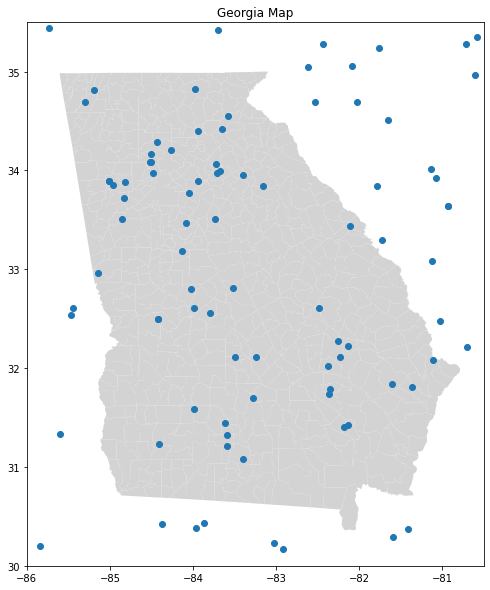

In [26]:
georgia_map = gpd.read_file('georgia/tl_2019_13_cousub.shp')

fig, ax = plt.subplots(figsize = (10,10))
georgia_map.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')
geo_df.plot(ax=ax)

ax.set_ylim(30, 35.5)
ax.set_xlim(-86, -80.5)
ax.set_title('Georgia Map')